In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving 1429_1.csv to 1429_1.csv


In [3]:
df = pd.read_csv('1429_1.csv')
df.head()

<ipython-input-3-5fb8df98627f>:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('1429_1.csv')


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [4]:
df = df[['reviews.text', 'reviews.rating']].dropna()
df.columns = ['text', 'rating']

def rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(rating_to_sentiment)

df = df[df['sentiment'] != 'neutral']
df.reset_index(drop=True, inplace=True)

df.head()

,text,rating,sentiment
0,This product so far has not disappointed. My c...,5.0,positive
1,great for beginner or experienced person. Boug...,5.0,positive
2,Inexpensive tablet for him to use and learn on...,5.0,positive
3,I've had my Fire HD 8 two weeks now and I love...,4.0,positive
4,I bought this for my grand daughter when she c...,5.0,positive


In [5]:
STOPWORDS = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    return text

df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text', 'sentiment']].head()

,text,clean_text,sentiment
0,This product so far has not disappointed. My c...,product far disappointed children love use lik...,positive
1,great for beginner or experienced person. Boug...,great beginner experienced person bought gift ...,positive
2,Inexpensive tablet for him to use and learn on...,inexpensive tablet use learn step nabi thrille...,positive
3,I've had my Fire HD 8 two weeks now and I love...,ive fire hd two weeks love tablet great valuew...,positive
4,I bought this for my grand daughter when she c...,bought grand daughter comes visit set user ent...,positive


In [6]:
X = df['clean_text']
y = df['sentiment']

tfidf = TfidfVectorizer(max_features=5000)
X_vectorized = tfidf.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

Classification Report:

              precision    recall  f1-score   support

    negative       1.00      0.01      0.01       162
    positive       0.98      1.00      0.99      6464

    accuracy                           0.98      6626
   macro avg       0.99      0.50      0.50      6626
weighted avg       0.98      0.98      0.96      6626

Confusion Matrix:



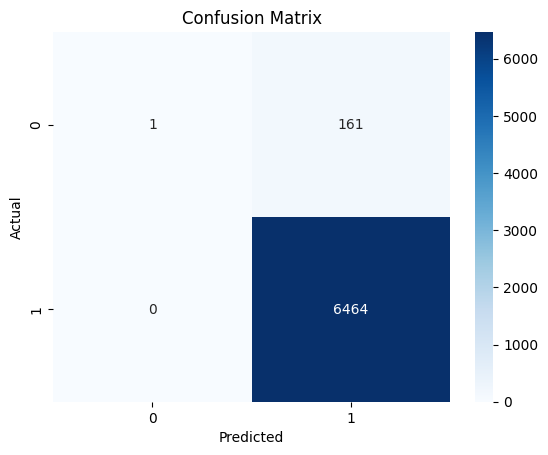

In [9]:
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
from sklearn.utils import resample

positive_df = df[df['sentiment'] == 'positive']
negative_df = df[df['sentiment'] == 'negative']

positive_downsampled = resample(
    positive_df,
    replace=False,
    n_samples=len(negative_df),
    random_state=42
)

balanced_df = pd.concat([positive_downsampled, negative_df])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df['sentiment'].value_counts()

,count
sentiment,
positive,812
negative,812


In [11]:
balanced_df['clean_text'] = balanced_df['text'].apply(clean_text)

In [12]:
X = balanced_df['clean_text']
y = balanced_df['sentiment']

tfidf = TfidfVectorizer(max_features=5000)
X_vectorized = tfidf.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42, stratify=y
)

Classification Report:

              precision    recall  f1-score   support

    negative       0.83      0.89      0.86       163
    positive       0.88      0.82      0.85       162

    accuracy                           0.86       325
   macro avg       0.86      0.86      0.86       325
weighted avg       0.86      0.86      0.86       325

Confusion Matrix:



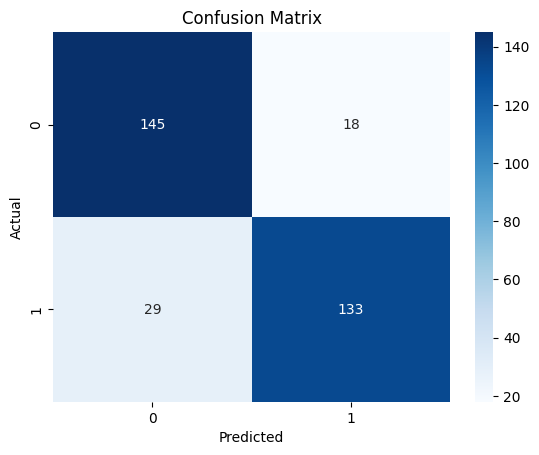

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vectorized = tfidf.transform([cleaned])
    prediction = model.predict(vectorized)
    return prediction[0]

comment = input("Your comment: ")
result = predict_sentiment(comment)
print(f"result: {result}")
